In [3]:
pip install gensim

  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.23
    Uninstalling Cython-0.29.23:
      Successfully uninstalled Cython-0.29.23
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install pymorphy2

  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=d9b0bb21d9b46bbc05f78a16ecacc056bd4da650a998c062da563682cd207291
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\56\ea\58\ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install razdel


Note: you may need to restart the kernel to use updated packages.


In [7]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [10]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор
import pandas as pd
import nltk
from nltk.corpus import stopwords

In [13]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [15]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [21]:

stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [22]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords

In [23]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [24]:
%%time
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста. Будет долго...
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

  0%|          | 0/27000 [00:00<?, ?it/s]<ipython-input-23-898b573b2830>:14: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
100%|██████████| 27000/27000 [00:22<00:00, 1193.01it/s]

Wall time: 22.7 s


In [25]:
%%time
# Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|██████████| 27000/27000 [02:51<00:00, 157.23it/s]

Wall time: 2min 51s


In [26]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [27]:

N_topic = 10

In [30]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, passes=5)

Wall time: 1min 20s


In [31]:
from gensim.test.utils import datapath

# Сохраняем модель на диск
temp_file = datapath("model.lda")
lda.save(temp_file)

In [32]:
# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [33]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [34]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

Wall time: 14.5 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,6,0.000000,0.000000,0.027682,0.034353,0.102994,0.791666,0.0,0.0,0.023141,0.016554
1,4896,0.000000,0.000000,0.109641,0.000000,0.870349,0.000000,0.0,0.0,0.000000,0.000000
2,4897,0.000000,0.020782,0.463010,0.000000,0.434180,0.000000,0.0,0.0,0.034074,0.036805
3,4898,0.092252,0.000000,0.561277,0.000000,0.217723,0.000000,0.0,0.0,0.000000,0.121481
4,4899,0.000000,0.000000,0.000000,0.000000,0.167147,0.810564,0.0,0.0,0.000000,0.000000


In [35]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [36]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [37]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.mean(user_vector, 0)  # можно не среднее
    return user_vector

In [38]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

Wall time: 258 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,u105138,0.146894,0.0,0.073379,0.009335,0.025770,0.245458,0.389219,0.079561,0.015241,0.004565
1,u108690,0.236820,0.0,0.158492,0.002123,0.027646,0.320844,0.076353,0.109120,0.016672,0.042061
2,u108339,0.301541,0.0,0.068751,0.025143,0.063409,0.282365,0.121921,0.058522,0.042379,0.031237


In [39]:
user_embeddings.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,u105138,0.146894,0.000000,0.073379,0.009335,0.025770,0.245458,0.389219,0.079561,0.015241,0.004565
1,u108690,0.236820,0.000000,0.158492,0.002123,0.027646,0.320844,0.076353,0.109120,0.016672,0.042061
2,u108339,0.301541,0.000000,0.068751,0.025143,0.063409,0.282365,0.121921,0.058522,0.042379,0.031237
3,u101138,0.018186,0.010938,0.316760,0.004124,0.189958,0.063088,0.039996,0.080111,0.034466,0.234168
4,u108248,0.189777,0.002203,0.187574,0.036300,0.004225,0.283276,0.223501,0.034990,0.024565,0.007373


In [40]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [41]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,churn
0,u105138,0.146894,0.0,0.073379,0.009335,0.025770,0.245458,0.389219,0.079561,0.015241,0.004565,0
1,u108690,0.236820,0.0,0.158492,0.002123,0.027646,0.320844,0.076353,0.109120,0.016672,0.042061,1
2,u108339,0.301541,0.0,0.068751,0.025143,0.063409,0.282365,0.121921,0.058522,0.042379,0.031237,1


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [43]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [44]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [45]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.07134259, 0.02529457, 0.35940663, 0.20459103, 0.22776094,
       0.08717696, 0.07858416, 0.03580068, 0.07031426, 0.07717831])

In [46]:
#### Precision, Recall, F_score

In [47]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

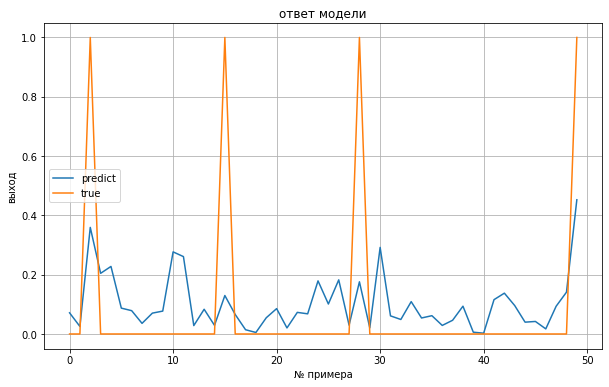

In [48]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [59]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test, preds)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
# locate the index of the largest f score
ix_mean = np.argmax(fscore_mean)
print('Best Threshold_mean=%f, F-Score_mean=%.3f, Precision_mean=%.3f, Recall_mean=%.3f' % (thresholds_mean[ix_mean], 
                                                                        fscore_mean[ix_mean],
                                                                        precision_mean[ix_mean],
                                                                        recall_mean[ix_mean]))

Best Threshold_mean=0.228331, F-Score_mean=0.606, Precision_mean=0.514, Recall_mean=0.739


In [60]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1584  171]
 [  65  180]]


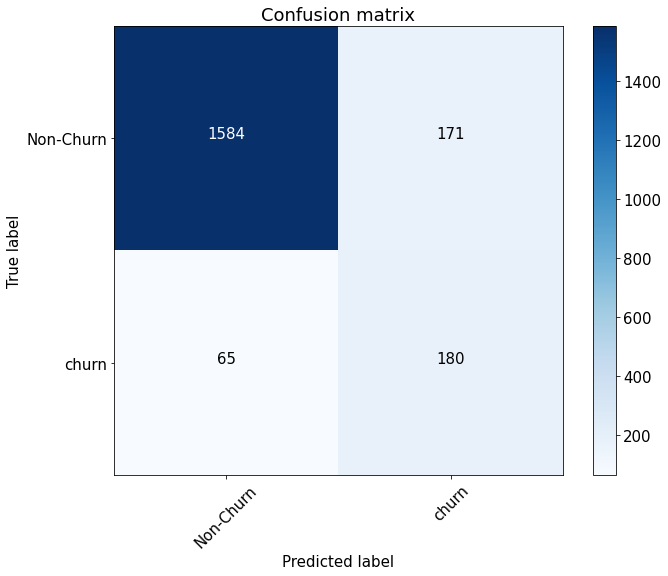

In [61]:
import itertools
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [63]:
roc_mean = roc_auc_score(y_test, preds)
roc_mean

0.9281260538403396

In [64]:
#### Использование медианы для преобразования
def get_user_embedding_median(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.median(user_vector, 0) 
    return user_vector

In [65]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]

Wall time: 515 ms


In [66]:
X = pd.merge(user_embeddings, target, 'left')

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [68]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [69]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.0550646 , 0.02545367, 0.35011308, 0.26968554, 0.14435057,
       0.16498869, 0.11518336, 0.01070167, 0.06018849, 0.05545432])

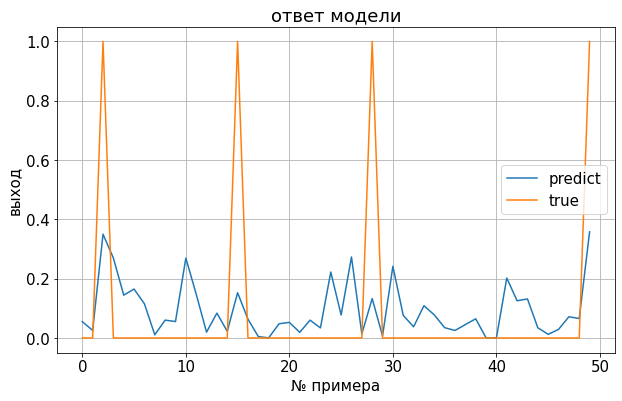

In [70]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [71]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test, preds)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix_median = np.argmax(fscore_median)
print('Best Threshold_median=%f, F-Score_median=%.3f, Precision_median=%.3f, Recall_median=%.3f' % (thresholds_median[ix_median], 
                                                                        fscore_median[ix_median],
                                                                        precision_median[ix_median],
                                                                        recall_median[ix_median]))

Best Threshold_median=0.210168, F-Score_median=0.595, Precision_median=0.477, Recall_median=0.792


In [72]:
roc_median = roc_auc_score(y_test, preds)
roc_median

0.9167091109948253

In [73]:
#### Использование max для преобразования

In [101]:
def get_user_embedding_max(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.max(user_vector, 0) 
    return user_vector

In [102]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]

Wall time: 192 ms


In [103]:
X = pd.merge(user_embeddings, target, 'left')

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [105]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [106]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.03898554, 0.0229779 , 0.29433437, 0.14361599, 0.1575767 ,
       0.0097786 , 0.02905882, 0.1430903 , 0.11811639, 0.16261588])

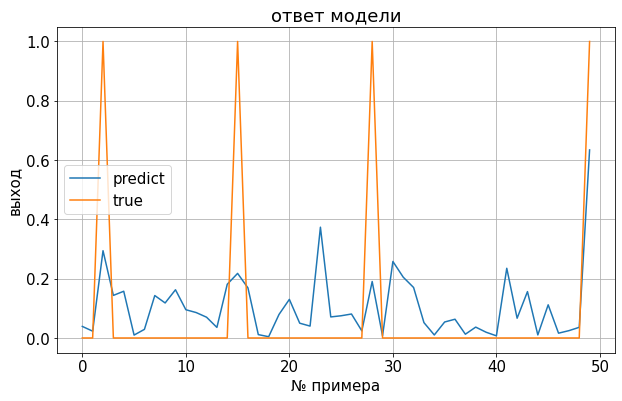

In [107]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [100]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_test, preds)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix_max = np.argmax(fscore_max)
print('Best Threshold_max=%f, F-Score_max=%.3f, Precision_max=%.3f, Recall_max=%.3f' % (thresholds_max[ix_max], 
                                                                        fscore_max[ix_max],
                                                                        precision_max[ix_max],
                                                                        recall_max[ix_max]))

Best Threshold_max=0.854004, F-Score_max=nan, Precision_max=0.000, Recall_max=0.000


<ipython-input-100-a46af158acc9>:2: RuntimeWarning: invalid value encountered in true_divide
  fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)


In [109]:
roc_max = roc_auc_score(y_test, preds)
roc_max

0.8951334379905809

In [112]:
print('Best Threshold_mean=%f, F-Score_mean=%.3f, Precision_mean=%.3f, Recall_mean=%.3f, roc_mean=%f' % (thresholds_mean[ix_mean], 
                                                                        fscore_mean[ix_mean],
                                                                        precision_mean[ix_mean],
                                                                        recall_mean[ix_mean],
                                                                        roc_mean))
print('Best Threshold_median=%f, F-Score_median=%.3f, Precision_median=%.3f, Recall_median=%.3f, roc_median=%f' % (thresholds_median[ix_median], 
                                                                        fscore_median[ix_median],
                                                                        precision_median[ix_median],
                                                                        recall_median[ix_median],
                                                                        roc_median))
print('Best Threshold_max=%f, F-Score_max=%.3f, Precision_max=%.3f, Recall_max=%.3f, roc_max=%f' % (thresholds_max[ix_max], 
                                                                        fscore_max[ix_max],
                                                                        precision_max[ix_max],
                                                                        recall_max[ix_max],
                                                                        roc_max))

Best Threshold_mean=0.228331, F-Score_mean=0.606, Precision_mean=0.514, Recall_mean=0.739, roc_mean=0.928126
Best Threshold_median=0.210168, F-Score_median=0.595, Precision_median=0.477, Recall_median=0.792, roc_median=0.916709
Best Threshold_max=0.854004, F-Score_max=nan, Precision_max=0.000, Recall_max=0.000, roc_max=0.895133


In [ ]:
# С методом max почему то не задолось, отказывается считать, поэтому я его ставлю на последнее место 
# Наиболее лучше себе проявляет метод mean 